In [1]:
import pandas as pd
import requests
import concurrent.futures
from datetime import datetime, timedelta
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import yfinance as yf
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf
import nltk

# Download the VADER lexicon required for sentiment analysis
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\TAMILSELVAN\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
# Define API keys
API_KEY_GUARDIAN = "b001c2f9-9358-4483-a3bc-da632b995c95"
NEWS_API_KEY = "0bbb8dd5a0754e0fb14d9364e924d9e0"
SHELL_TICKER = 'SHEL'
BP_TICKER = 'BP'

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()


### Fetch and Analyse Guardian News Data

In [3]:
def fetch_data_guardian(url):
    """
    Fetch data from the Guardian API.
    
    Parameters:
        url (str): API endpoint for the Guardian news data.
    
    Returns:
        dict: JSON response from the API.
    """
    try:
        response = requests.get(url)
        response.raise_for_status()
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data from {url}: {e}")
        return None

In [4]:
def fetch_article_content_guardian(api_url):
    """
    Fetch the content and description of an article from the Guardian API.
    
    Parameters:
        api_url (str): API endpoint for the specific article.
    
    Returns:
        tuple: Article content and description.
    """
    try:
        response = requests.get(api_url + "?api-key=" + API_KEY_GUARDIAN + "&show-fields=body,trailText")
        response.raise_for_status()
        data = response.json()
        content = data['response']['content']['fields'].get('body', 'No content available')
        description = data['response']['content']['fields'].get('trailText', 'No description available')
        return content, description
    except requests.exceptions.RequestException as e:
        print(f"Error fetching article content from {api_url}: {e}")
        return None, None
    except KeyError as e:
        print(f"Error parsing article content: {e}")
        return None, None

In [5]:
def extract_info_guardian(json_data):
    """
    Extract relevant information from the JSON response.
    
    Parameters:
        json_data (dict): JSON response from the Guardian API.
    
    Returns:
        list: Extracted information including title, section name, publication date, and API URL.
    """
    if not json_data:
        return []
    try:
        articles = json_data['response']['results']
        return [
            {
                'title': article['webTitle'],
                'sectionname': article['sectionName'],
                'publisheddate': article['webPublicationDate'],
                'api_url': article['apiUrl']
            } for article in articles
        ]
    except KeyError as e:
        print(f"Error parsing data: {e}")
        return []


In [6]:
def analyze_sentiment_vader(text):
    """
    Analyze the sentiment of the given text using VADER.
    
    Parameters:
        text (str): The text to analyze.
    
    Returns:
        float: The compound sentiment score.
    """
    vs = analyzer.polarity_scores(text)
    return vs['compound']

In [7]:
def fetch_guardian_news():
    """
    Fetch and analyze Guardian news articles related to oil.
    
    Returns:
        pd.DataFrame: DataFrame containing the sentiment scores of Guardian news articles.
    """
    # Define a list of URLs to fetch data from multiple pages
    urllist = []
    for i in range(1, 17):
        base_url = "https://content.guardianapis.com/business/oil?from-date=2023-01-01&api-key=" + API_KEY_GUARDIAN + "&type=article&page="
        url = base_url + str(i)
        urllist.append(url)

    urls = urllist
    
    # Use ThreadPoolExecutor to fetch data concurrently
    with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
        json_data_list = list(executor.map(fetch_data_guardian, urls))
    
    info = []
    for json_data in json_data_list:
        info.extend(extract_info_guardian(json_data))
    
    if info:
        # Fetch content and description for each article concurrently
        with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
            content_and_descriptions = list(executor.map(fetch_article_content_guardian, [article['api_url'] for article in info]))
        
        for i, (content, description) in enumerate(content_and_descriptions):
            if content and description:
                info[i]['content'] = content
                info[i]['description'] = description
            else:
                info[i]['content'] = 'No content available'
                info[i]['description'] = 'No description available'
            info[i].pop('api_url')  # Remove api_url from the final data

        # Convert to DataFrame
        df = pd.DataFrame(info)

        # Perform sentiment analysis on title, description, and content
        df['title_sentiment'] = df['title'].map(analyze_sentiment_vader)
        df['description_sentiment'] = df['description'].map(analyze_sentiment_vader)
        df['content_sentiment'] = df['content'].map(analyze_sentiment_vader)
        
        # Convert publisheddate to datetime format and then to date
        df['publisheddate'] = pd.to_datetime(df['publisheddate']).dt.date
        
        # Select only numeric columns for grouping
        sentiment_columns = ['title_sentiment', 'description_sentiment', 'content_sentiment']
        
        # Group by date and calculate the mean of sentiment scores
        sentiment_df = df.groupby('publisheddate')[sentiment_columns].mean().reset_index()

        # Rename 'publisheddate' to 'date'
        sentiment_df.rename(columns={'publisheddate': 'date'}, inplace=True)

        # Save the sentiment analysis DataFrame to a CSV file
        sentiment_df.to_csv('guardian_oil_articles_vader_sentiment.csv', index=False)

        return sentiment_df
    else:
        print("No data found")
        return pd.DataFrame()


### Fetch and Analyse NewsAPI Data

In [8]:
def fetch_news_for_date(api_key, query, date):
    """
    Fetch news articles from the News API for a specific date.
    
    Parameters:
        api_key (str): News API key.
        query (str): Query string for news articles.
        date (str): Date in YYYY-MM-DD format.
    
    Returns:
        dict: JSON response from the News API.
    """
    url = (f"https://newsapi.org/v2/everything?"
           f"q={query}&from={date}&to={date}&"
           f"sortBy=publishedAt&apiKey={api_key}&pageSize=100&page=1")
    response = requests.get(url)
    return response.json()

In [9]:
def preprocess_news(articles):
    """
    Preprocess the news articles DataFrame by removing duplicates and null values.
    
    Parameters:
        articles (list): List of articles with their details.
    
    Returns:
        pd.DataFrame: Preprocessed DataFrame containing news articles.
    """
    news_df = pd.DataFrame(articles)
    news_df['publishedAt'] = pd.to_datetime(news_df['publishedAt'])
    news_df = news_df.drop_duplicates(subset='url')
    news_df = news_df[['publishedAt', 'title', 'description', 'content', 'url']]
    news_df = news_df.dropna(subset=['title', 'description', 'content'])
    return news_df

In [10]:
def fetch_and_aggregate_sentiment(api_key, query, start_date, end_date):
    """
    Fetch and aggregate sentiment scores for news articles within a date range.
    
    Parameters:
        api_key (str): News API key.
        query (str): Query string for news articles.
        start_date (datetime): Start date for fetching articles.
        end_date (datetime): End date for fetching articles.
    
    Returns:
        pd.DataFrame: DataFrame containing aggregated sentiment scores by date.
    """
    current_date = start_date
    all_aggregate_sentiments = []

    # Iterate over each date in the range
    while current_date <= end_date:
        news_data = fetch_news_for_date(api_key, query, current_date.strftime('%Y-%m-%d'))
        
        if 'articles' in news_data:
            articles = news_data['articles']
            news_df = preprocess_news(articles)
            
            if not news_df.empty:
                # Perform sentiment analysis on title, description, and content
                news_df['title_sentiment'] = news_df['title'].apply(analyze_sentiment_vader)
                news_df['description_sentiment'] = news_df['description'].apply(analyze_sentiment_vader)
                news_df['content_sentiment'] = news_df['content'].apply(analyze_sentiment_vader)

                # Aggregate sentiment scores by date
                aggregate_sentiment = {
                    'date': current_date.strftime('%Y-%m-%d'),
                    'mean_title_sentiment': news_df['title_sentiment'].mean(),
                    'mean_description_sentiment': news_df['description_sentiment'].mean(),
                    'mean_content_sentiment': news_df['content_sentiment'].mean()
                }
            else:
                aggregate_sentiment = {
                    'date': current_date.strftime('%Y-%m-%d'),
                    'mean_title_sentiment': None,
                    'mean_description_sentiment': None,
                    'mean_content_sentiment': None
                }
        else:
            print(f"No articles found for {current_date.strftime('%Y-%m-%d')} or API error.")
            aggregate_sentiment = {
                'date': current_date.strftime('%Y-%m-%d'),
                'mean_title_sentiment': None,
                'mean_description_sentiment': None,
                'mean_content_sentiment': None
            }
        
        all_aggregate_sentiments.append(aggregate_sentiment)
        current_date += timedelta(days=1)

    return pd.DataFrame(all_aggregate_sentiments)

### Main Execution: Fetch and Combine Sentiments

In [11]:
# Define query and date range for fetching news data
news_query = 'oil'
news_start_date = datetime.strptime('2024-07-27', '%Y-%m-%d')
news_end_date = datetime.strptime('2024-08-26', '%Y-%m-%d')

# Fetch and aggregate sentiment scores for the specified date range
news_sentiments_df = fetch_and_aggregate_sentiment(NEWS_API_KEY, news_query, news_start_date, news_end_date)

# Ensure 'date' is in date format
news_sentiments_df['date'] = pd.to_datetime(news_sentiments_df['date']).dt.date

# Group by date and calculate the mean of sentiment scores where dates overlap
news_sentiments_df = news_sentiments_df.groupby('date').mean().reset_index()

# Save the aggregated sentiment DataFrame to a CSV file
news_sentiments_df.to_csv('news_vader_sentiment.csv', index=False)

# Display the aggregated sentiment DataFrame
print(news_sentiments_df)

          date  mean_title_sentiment  mean_description_sentiment  \
0   2024-07-27             -0.054830                    0.039649   
1   2024-07-28              0.045492                    0.050066   
2   2024-07-29             -0.023891                    0.057149   
3   2024-07-30             -0.035898                    0.127338   
4   2024-07-31              0.036955                    0.175823   
5   2024-08-01              0.031121                    0.218641   
6   2024-08-02             -0.027982                    0.205754   
7   2024-08-03             -0.079191                    0.005766   
8   2024-08-04             -0.099167                    0.025323   
9   2024-08-05             -0.046302                   -0.000366   
10  2024-08-06              0.048172                    0.096537   
11  2024-08-07              0.011887                    0.085471   
12  2024-08-08              0.022435                    0.220525   
13  2024-08-09             -0.064706            

In [12]:
# Fetch Guardian news sentiments
guardian_sentiments_df = fetch_guardian_news()

# Combine both DataFrames
combined_sentiments_df = pd.concat([guardian_sentiments_df, news_sentiments_df])

# Group by date and calculate the mean of sentiment scores
combined_sentiments_df = combined_sentiments_df.groupby('date').mean().reset_index()

# Save the combined DataFrame to a CSV file
combined_sentiments_df.to_csv('combined_vader_sentiment.csv', index=False)

# Display the combined DataFrame
print(combined_sentiments_df)

           date  title_sentiment  description_sentiment  content_sentiment  \
0    2023-10-25         -0.13660                0.38275           -0.05590   
1    2023-10-26         -0.44040               -0.45880            0.69140   
2    2023-10-30         -0.10270               -0.73510           -0.99550   
3    2023-10-31          0.33755               -0.31245            0.98105   
4    2023-11-02         -0.51060               -0.27320           -0.98890   
..          ...              ...                    ...                ...   
142  2024-08-22         -0.45880                0.42150            0.29890   
143  2024-08-23              NaN                    NaN                NaN   
144  2024-08-24              NaN                    NaN                NaN   
145  2024-08-25              NaN                    NaN                NaN   
146  2024-08-26              NaN                    NaN                NaN   

     mean_title_sentiment  mean_description_sentiment  mean_con

### Combine Sentiment Data and Prepare for Stock Analysis

In [13]:
# Load the combined sentiment data
combined_sentiments_df = pd.read_csv('combined_vader_sentiment.csv')

# Average the sentiment columns, handling NaNs
combined_sentiments_df['avg_title_sentiment'] = combined_sentiments_df[['title_sentiment', 'mean_title_sentiment']].mean(axis=1, skipna=True)
combined_sentiments_df['avg_description_sentiment'] = combined_sentiments_df[['description_sentiment', 'mean_description_sentiment']].mean(axis=1, skipna=True)
combined_sentiments_df['avg_content_sentiment'] = combined_sentiments_df[['content_sentiment', 'mean_content_sentiment']].mean(axis=1, skipna=True)

# Drop the original sentiment columns
combined_sentiments_df.drop(columns=['title_sentiment', 'description_sentiment', 'content_sentiment', 'mean_title_sentiment', 'mean_description_sentiment', 'mean_content_sentiment'], inplace=True)

# Save the updated DataFrame to a CSV file
combined_sentiments_df.to_csv('updated_combined_vader_sentiment.csv', index=False)

# Display the updated DataFrame
print(combined_sentiments_df)

           date  avg_title_sentiment  avg_description_sentiment  \
0    2023-10-25            -0.136600                   0.382750   
1    2023-10-26            -0.440400                  -0.458800   
2    2023-10-30            -0.102700                  -0.735100   
3    2023-10-31             0.337550                  -0.312450   
4    2023-11-02            -0.510600                  -0.273200   
..          ...                  ...                        ...   
142  2024-08-22            -0.222950                   0.263623   
143  2024-08-23            -0.001776                   0.156228   
144  2024-08-24            -0.027390                   0.047260   
145  2024-08-25             0.001033                   0.113503   
146  2024-08-26             0.020029                   0.005880   

     avg_content_sentiment  
0                -0.055900  
1                 0.691400  
2                -0.995500  
3                 0.981050  
4                -0.988900  
..                   

### Visualize Sentiment Data

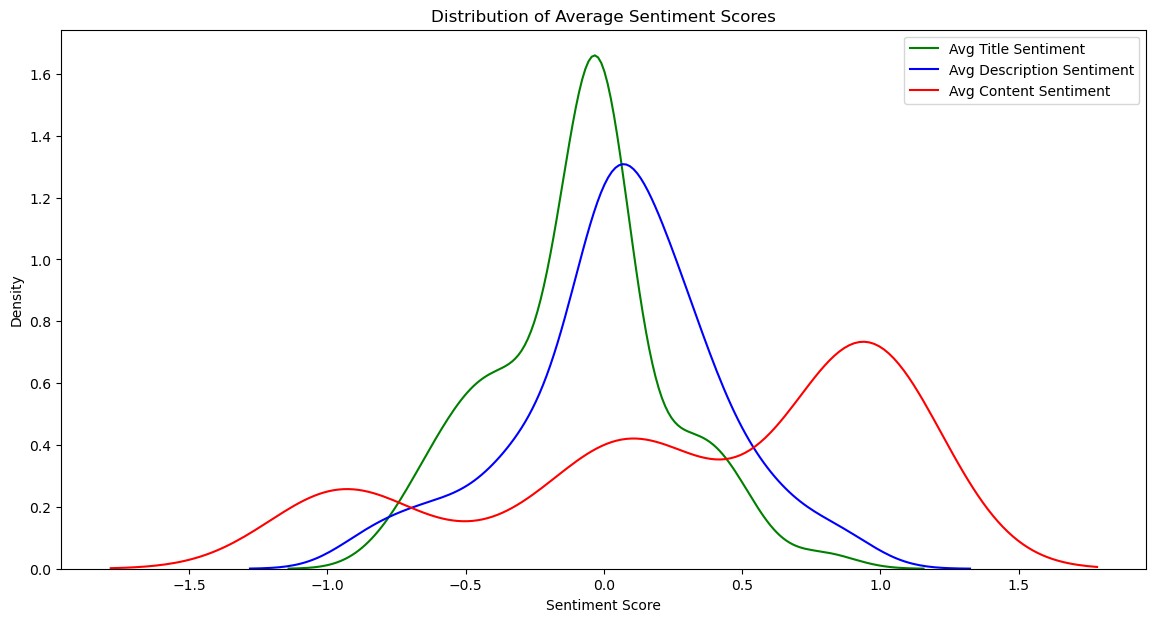

In [14]:
# Load the updated combined sentiment data
combined_sentiments_df = pd.read_csv('updated_combined_vader_sentiment.csv')

# Create a figure and axis for the plot
plt.figure(figsize=(14, 7))

# Plot the KDE for average title sentiment scores without shading
sns.kdeplot(combined_sentiments_df['avg_title_sentiment'], color='green', label='Avg Title Sentiment')

# Plot the KDE for average description sentiment scores without shading
sns.kdeplot(combined_sentiments_df['avg_description_sentiment'], color='blue', label='Avg Description Sentiment')

# Plot the KDE for average content sentiment scores without shading
sns.kdeplot(combined_sentiments_df['avg_content_sentiment'], color='red', label='Avg Content Sentiment')

# Add titles and labels
plt.title('Distribution of Average Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.legend()

# Show the plot
plt.show()

### Fetch and Combine Stock Data with Sentiments

In [18]:
def fetch_stock_data(ticker, start_date, end_date):
    """
    Fetch historical stock data using yFinance.
    
    Parameters:
        ticker (str): Stock ticker symbol.
        start_date (str): Start date in YYYY-MM-DD format.
        end_date (str): End date in YYYY-MM-DD format.
    
    Returns:
        pd.DataFrame: DataFrame containing the stock data.
    """
    stock = yf.Ticker(ticker)
    stock_data = stock.history(start=start_date, end=end_date)
    return stock_data

# Ensure 'date' column is in datetime format
combined_sentiments_df['date'] = pd.to_datetime(combined_sentiments_df['date'])

# Define the date range based on sentiment score data
start_date = combined_sentiments_df['date'].min().strftime('%Y-%m-%d')
end_date = combined_sentiments_df['date'].max().strftime('%Y-%m-%d')

In [19]:
# Fetch historical stock data for Shell
SHELL_TICKER = 'SHEL'
shell_stock_data = fetch_stock_data(SHELL_TICKER, start_date, end_date)

# Reset index to have 'Date' as a column
shell_stock_data.reset_index(inplace=True)

# Ensure the 'Date' column is in datetime format
shell_stock_data['Date'] = pd.to_datetime(shell_stock_data['Date'])

# Extract only the date part from the 'Date' column
shell_stock_data['Date'] = shell_stock_data['Date'].dt.date

# Select relevant columns
shell_stock_data = shell_stock_data[['Date', 'Open', 'High', 'Low', 'Close']]

# Rename the 'Date' column to 'date'
shell_stock_data.rename(columns={'Date': 'date'}, inplace=True)

# Ensure the 'date' column in combined_sentiments_df is in datetime format and then to date
combined_sentiments_df['date'] = pd.to_datetime(combined_sentiments_df['date']).dt.date

# Combine the sentiment score DataFrame with the stock data DataFrame
shell_combined_df = pd.merge(combined_sentiments_df, shell_stock_data, on='date', how='inner')

# Save the combined DataFrame to a CSV file
shell_combined_df.to_csv('combined_vader_sentiment_stock_data_shell.csv', index=False)

# Display the combined DataFrame
print(shell_combined_df)

           date  avg_title_sentiment  avg_description_sentiment  \
0    2023-10-25            -0.136600                   0.382750   
1    2023-10-26            -0.440400                  -0.458800   
2    2023-10-30            -0.102700                  -0.735100   
3    2023-10-31             0.337550                  -0.312450   
4    2023-11-02            -0.510600                  -0.273200   
..          ...                  ...                        ...   
109  2024-08-19            -0.013406                   0.127293   
110  2024-08-20            -0.041604                   0.119175   
111  2024-08-21            -0.034180                   0.124884   
112  2024-08-22            -0.222950                   0.263623   
113  2024-08-23            -0.001776                   0.156228   

     avg_content_sentiment       Open       High        Low      Close  
0                -0.055900  64.275423  64.554089  64.092848  64.246597  
1                 0.691400  63.756527  63.814187 

In [20]:
# Fetch historical stock data for BP
BP_TICKER = 'BP'
bp_stock_data = fetch_stock_data(BP_TICKER, start_date, end_date)

# Reset index to have 'Date' as a column
bp_stock_data.reset_index(inplace=True)

# Ensure the 'Date' column is in datetime format
bp_stock_data['Date'] = pd.to_datetime(bp_stock_data['Date'])

# Extract only the date part from the 'Date' column
bp_stock_data['Date'] = bp_stock_data['Date'].dt.date

# Select relevant columns
bp_stock_data = bp_stock_data[['Date', 'Open', 'High', 'Low', 'Close']]

# Rename the 'Date' column to 'date'
bp_stock_data.rename(columns={'Date': 'date'}, inplace=True)

# Combine the sentiment score DataFrame with the stock data DataFrame
bp_combined_df = pd.merge(combined_sentiments_df, bp_stock_data, on='date', how='inner')

# Save the combined DataFrame to a CSV file
bp_combined_df.to_csv('combined_vader_sentiment_stock_data_bp.csv', index=False)

# Display the combined DataFrame
print(bp_combined_df)

           date  avg_title_sentiment  avg_description_sentiment  \
0    2023-10-25            -0.136600                   0.382750   
1    2023-10-26            -0.440400                  -0.458800   
2    2023-10-30            -0.102700                  -0.735100   
3    2023-10-31             0.337550                  -0.312450   
4    2023-11-02            -0.510600                  -0.273200   
..          ...                  ...                        ...   
109  2024-08-19            -0.013406                   0.127293   
110  2024-08-20            -0.041604                   0.119175   
111  2024-08-21            -0.034180                   0.124884   
112  2024-08-22            -0.222950                   0.263623   
113  2024-08-23            -0.001776                   0.156228   

     avg_content_sentiment       Open       High        Low      Close  
0                -0.055900  37.103161  37.264726  36.903581  37.122169  
1                 0.691400  36.694493  37.027127 

### Visualize Stock Data with Moving Averages

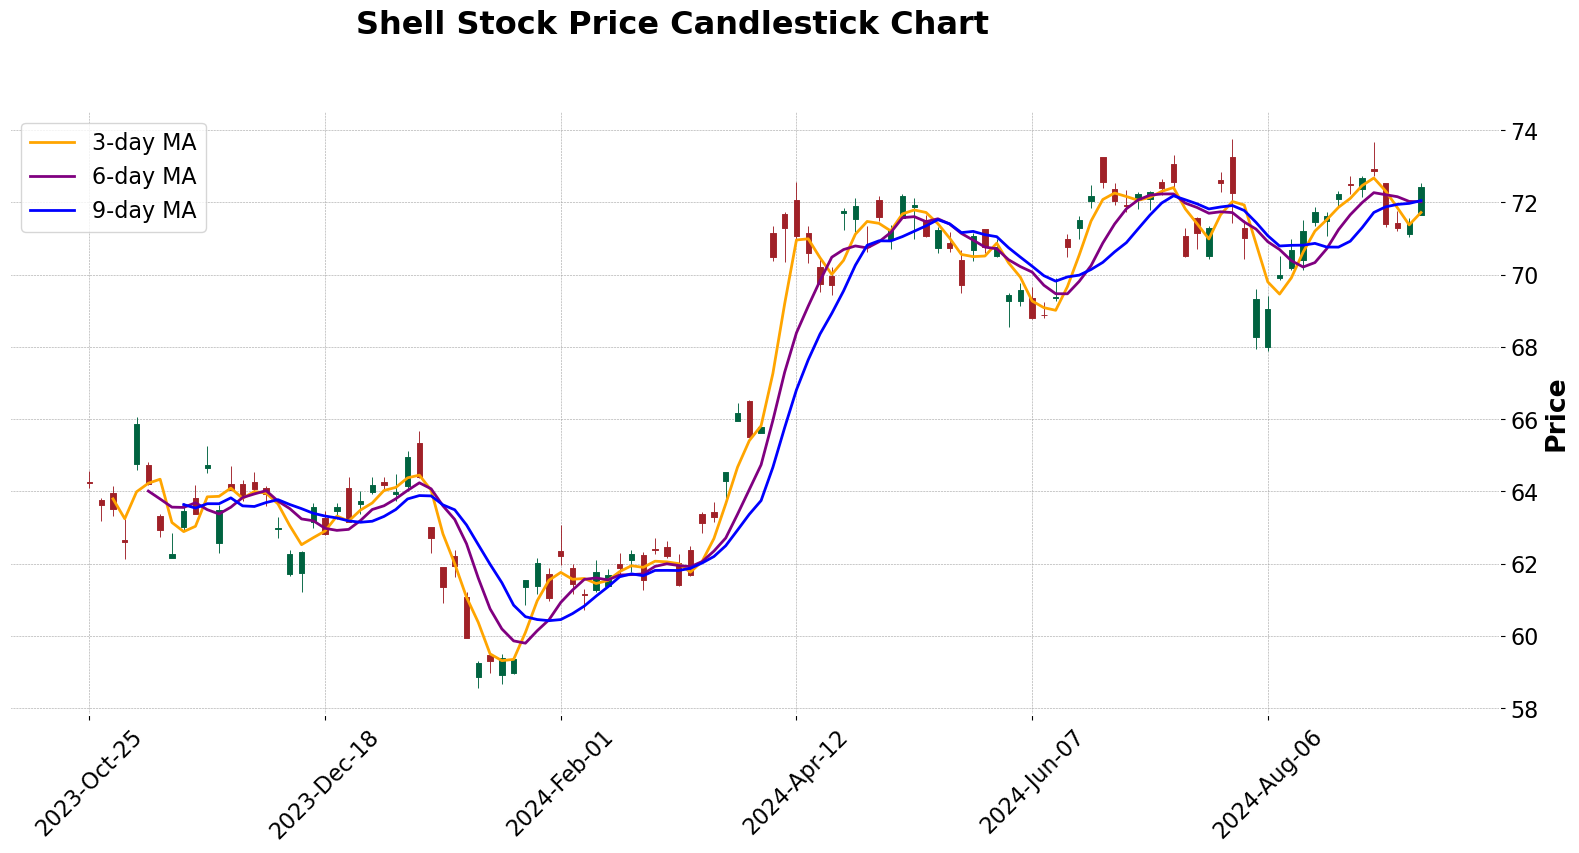

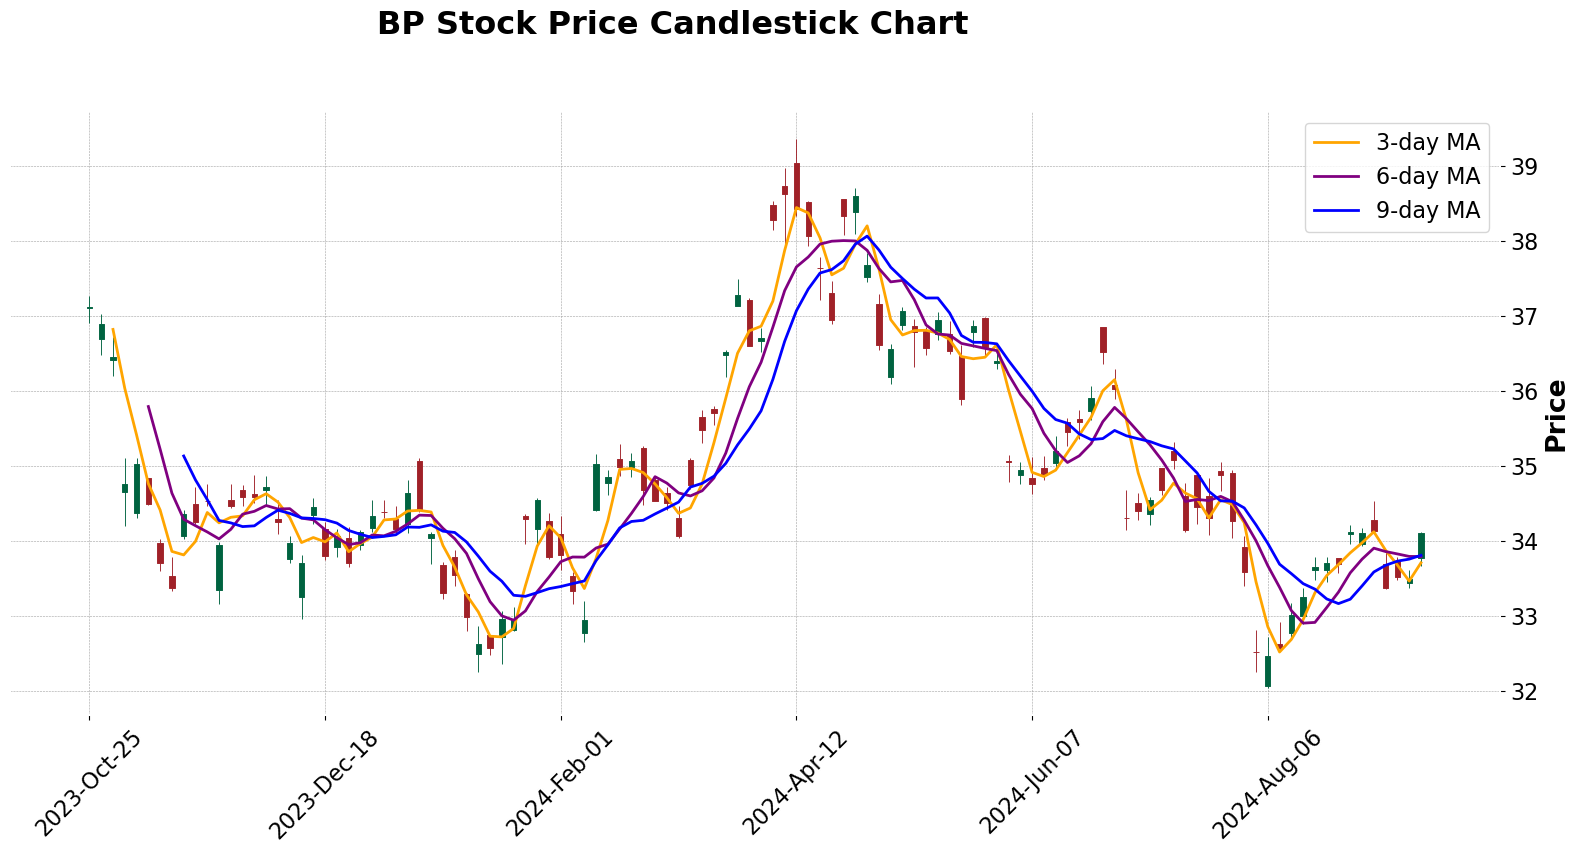

In [23]:
def plot_candlestick_with_moving_averages(data, ticker):
    """
    Plot a candlestick chart with moving averages for a given stock.
    
    Parameters:
        data (pd.DataFrame): DataFrame containing stock data.
        ticker (str): Stock ticker symbol.
    """
    # Set the 'date' column as the index and ensure it's a DatetimeIndex
    data = data.set_index('date')
    data.index = pd.to_datetime(data.index)

    # Calculate moving averages
    data['3_day_MA'] = data['Close'].rolling(window=3).mean()
    data['6_day_MA'] = data['Close'].rolling(window=6).mean()
    data['9_day_MA'] = data['Close'].rolling(window=9).mean()

    # Prepare data for candlestick chart
    stock_data = data[['Open', 'High', 'Low', 'Close']]

    # Define the style with increased font size
    my_style = mpf.make_mpf_style(base_mpf_style='charles', rc={'font.size': 16})

    # Create the plot with custom moving average colors
    apds = [
        mpf.make_addplot(data['3_day_MA'], color='orange', width=2, label='3-day MA'),
        mpf.make_addplot(data['6_day_MA'], color='purple', width=2, label='6-day MA'),
        mpf.make_addplot(data['9_day_MA'], color='blue', width=2, label='9-day MA')
    ]

    fig, ax = mpf.plot(stock_data, type='candle', style=my_style,
                       title=f'{ticker} Stock Price Candlestick Chart', ylabel='Price',
                       addplot=apds, returnfig=True, figratio=(24, 10), figscale=1.5)

    # Add legend
    handles, labels = ax[0].get_legend_handles_labels()
    ax[0].legend(handles=handles, labels=labels)
    
    # Save the figure as an image file
    plt.savefig(f'{ticker}_candlestick_chart.png')

    plt.show()

# Plot for Shell
plot_candlestick_with_moving_averages(shell_combined_df, 'Shell')

# Plot for BP
plot_candlestick_with_moving_averages(bp_combined_df, 'BP')


### Create Lagged Features for Stock Data

In [24]:
def create_lagged_features(data, columns):
    """
    Create lagged features for the specified columns in the DataFrame.
    
    Parameters:
        data (pd.DataFrame): DataFrame containing stock and sentiment data.
        columns (list): List of column names for which to create lagged features.
    
    Returns:
        pd.DataFrame: DataFrame with lagged features.
    """
    for col in columns:
        data[f'prev_{col}'] = data[col].shift(1)
    return data.dropna()

# Columns to create lagged features for
lagged_columns = ['avg_title_sentiment', 'avg_description_sentiment', 'avg_content_sentiment', 'Open', 'High', 'Low', 'Close']

# Create lagged features for Shell data
shell_combined_df = create_lagged_features(shell_combined_df, lagged_columns)

# Create lagged features for BP data
bp_combined_df = create_lagged_features(bp_combined_df, lagged_columns)


### Train and Evaluate Linear Regression Models

In [34]:
def train_and_evaluate(data, target_col, feature_cols):
    """
    Train and evaluate a linear regression model for the given target and features.
    
    Parameters:
        data (pd.DataFrame): DataFrame containing stock and sentiment data.
        target_col (str): Target column name.
        feature_cols (list): List of feature column names.
    
    Returns:
        tuple: True values, predicted values, MSE, and RMSE of the model.
    """
    X = data[feature_cols]
    y = data[target_col]

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

    # Train a linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate mean squared error and root mean squared error
    mse = mean_squared_error(y_test, y_pred)
    rmse = sqrt(mse)
    return y_test, y_pred, mse, rmse

# Define target and feature variables for both models
model_specs = [
    {
        'target_col': 'Open',
        'feature_cols': ['prev_avg_title_sentiment', 'prev_avg_description_sentiment', 'prev_avg_content_sentiment', 'prev_Close', 'prev_Open']
    },
    {
        'target_col': 'Close',
        'feature_cols': ['prev_avg_title_sentiment', 'prev_avg_description_sentiment', 'prev_avg_content_sentiment', 'Open', 'prev_Close']
    }
]

# Train and evaluate models for Shell data
print("Shell Data:")
shell_results = []
for spec in model_specs:
    y_test, y_pred, mse, rmse = train_and_evaluate(shell_combined_df, spec['target_col'], spec['feature_cols'])
    shell_results.append((y_test, y_pred, spec['target_col']))
    print(f"Model for {spec['target_col']} - MSE: {mse:.4f}, RMSE: {rmse:.4f}")

# Train and evaluate models for BP data
print("\nBP Data:")
bp_results = []
for spec in model_specs:
    y_test, y_pred, mse, rmse = train_and_evaluate(bp_combined_df, spec['target_col'], spec['feature_cols'])
    bp_results.append((y_test, y_pred, spec['target_col']))
    print(f"Model for {spec['target_col']} - MSE: {mse:.4f}, RMSE: {rmse:.4f}")


Shell Data:
Model for Open - MSE: 0.9254, RMSE: 0.9620
Model for Close - MSE: 0.3669, RMSE: 0.6057

BP Data:
Model for Open - MSE: 0.1671, RMSE: 0.4088
Model for Close - MSE: 0.0648, RMSE: 0.2545


###  Actual vs Predicted Prices Plot for Linear Regression

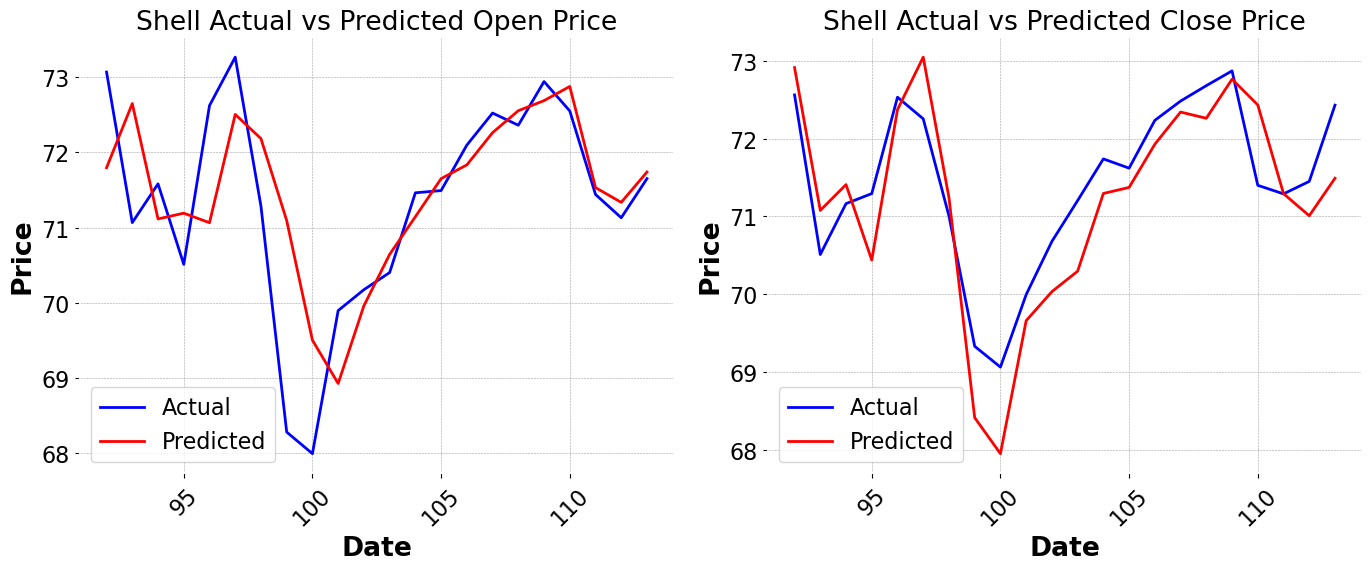

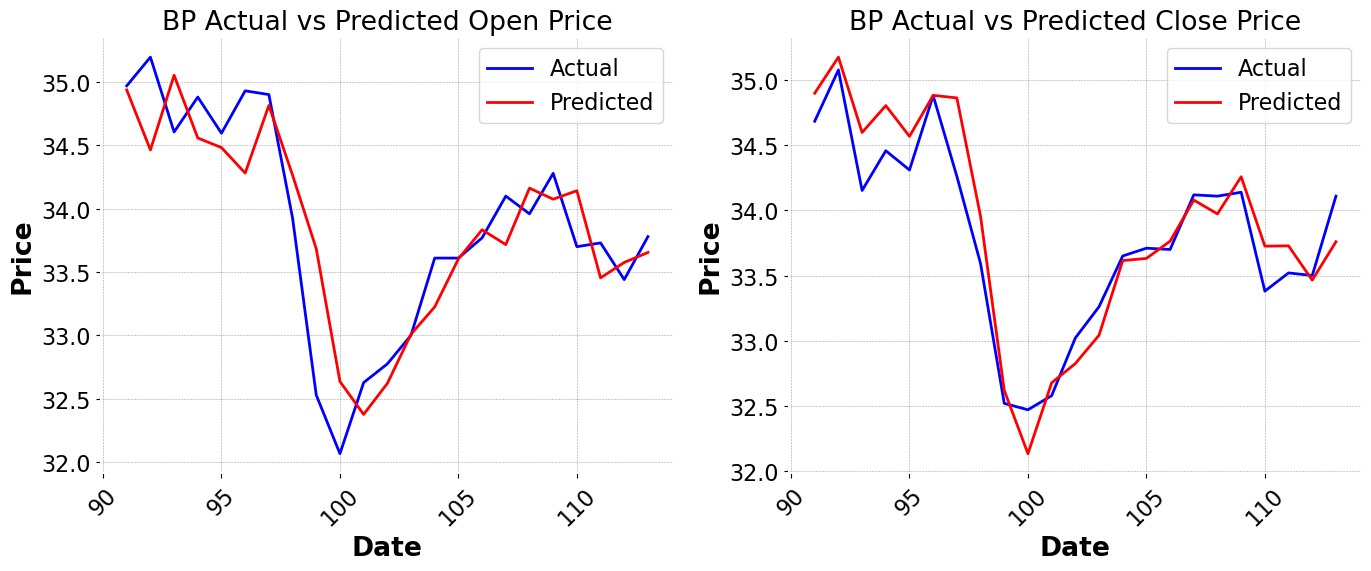

In [35]:
def plot_actual_vs_predicted(y_test, y_pred, ax, title):
    """
    Plot actual vs predicted prices.
    
    Parameters:
        y_test (pd.Series): True target values.
        y_pred (np.array): Predicted values.
        ax (matplotlib.axes.Axes): Axes object to plot on.
        title (str): Title of the plot.
    """
    ax.plot(y_test.index, y_test, label='Actual', color='blue')
    ax.plot(y_test.index, y_pred, label='Predicted', color='red')
    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.legend()
    ax.tick_params(axis='x', rotation=45)

# Plotting the results for Shell data
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for idx, result in enumerate(shell_results):
    y_test, y_pred, target_col = result
    plot_actual_vs_predicted(y_test, y_pred, axes[idx], f'Shell Actual vs Predicted {target_col} Price')

plt.tight_layout()
plt.show()

# Plotting the results for BP data
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for idx, result in enumerate(bp_results):
    y_test, y_pred, target_col = result
    plot_actual_vs_predicted(y_test, y_pred, axes[idx], f'BP Actual vs Predicted {target_col} Price')

plt.tight_layout()
plt.show()


### Train and Evaluate Random Forest Models

In [36]:
def train_and_evaluate_rf(data, target_col, feature_cols):
    """
    Train and evaluate a Random Forest model for the given target and features.
    
    Parameters:
        data (pd.DataFrame): DataFrame containing stock and sentiment data.
        target_col (str): Target column name.
        feature_cols (list): List of feature column names.
    
    Returns:
        tuple: True values, predicted values, MSE, and RMSE of the model.
    """
    X = data[feature_cols]
    y = data[target_col]

    # Splitting the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

    # Train the Random Forest Regressor model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)

    # Make predictions
    y_pred = rf_model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    
    return y_test, y_pred, mse, rmse

# Train and evaluate models for Shell data
print("Shell Data (Random Forest):")
shell_rf_results = []
for spec in model_specs:
    y_test, y_pred, mse, rmse = train_and_evaluate_rf(shell_combined_df, spec['target_col'], spec['feature_cols'])
    shell_rf_results.append((y_test, y_pred, spec['target_col']))
    print(f"Model for {spec['target_col']} - MSE: {mse:.4f}, RMSE: {rmse:.4f}")

# Train and evaluate models for BP data
print("\nBP Data (Random Forest):")
bp_rf_results = []
for spec in model_specs:
    y_test, y_pred, mse, rmse = train_and_evaluate_rf(bp_combined_df, spec['target_col'], spec['feature_cols'])
    bp_rf_results.append((y_test, y_pred, spec['target_col']))
    print(f"Model for {spec['target_col']} - MSE: {mse:.4f}, RMSE: {rmse:.4f}")


Shell Data (Random Forest):
Model for Open - MSE: 1.0960, RMSE: 1.0469
Model for Close - MSE: 0.3301, RMSE: 0.5746

BP Data (Random Forest):
Model for Open - MSE: 0.2148, RMSE: 0.4634
Model for Close - MSE: 0.1102, RMSE: 0.3319


### Actual vs Predicted Prices Plot for Random Forest

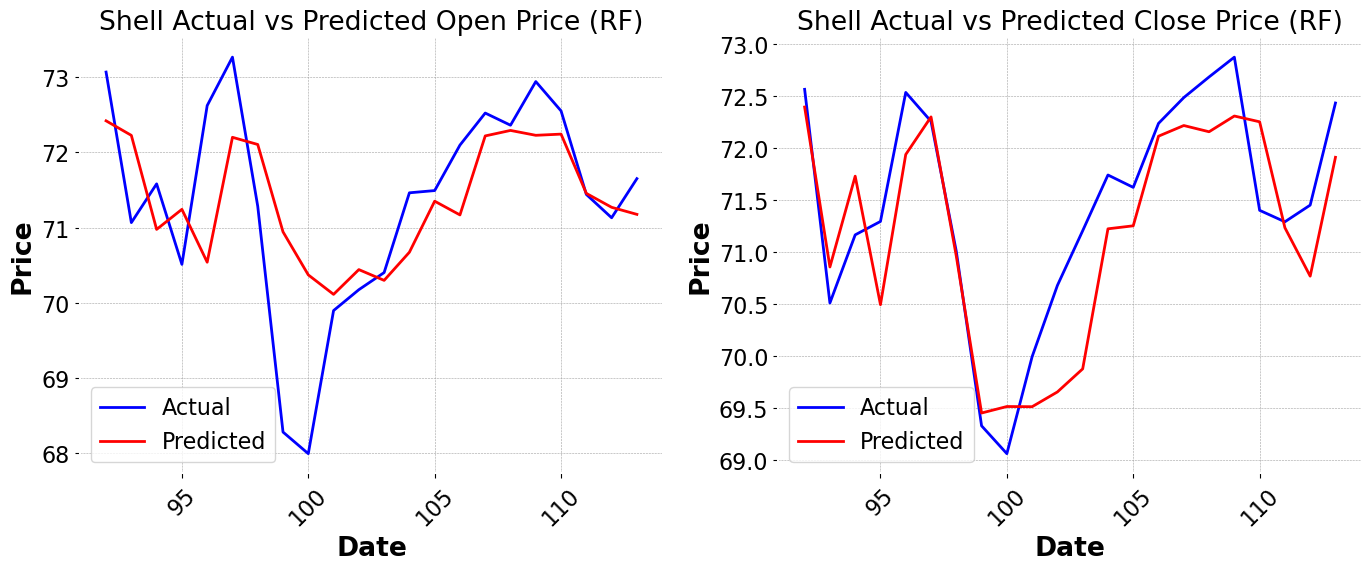

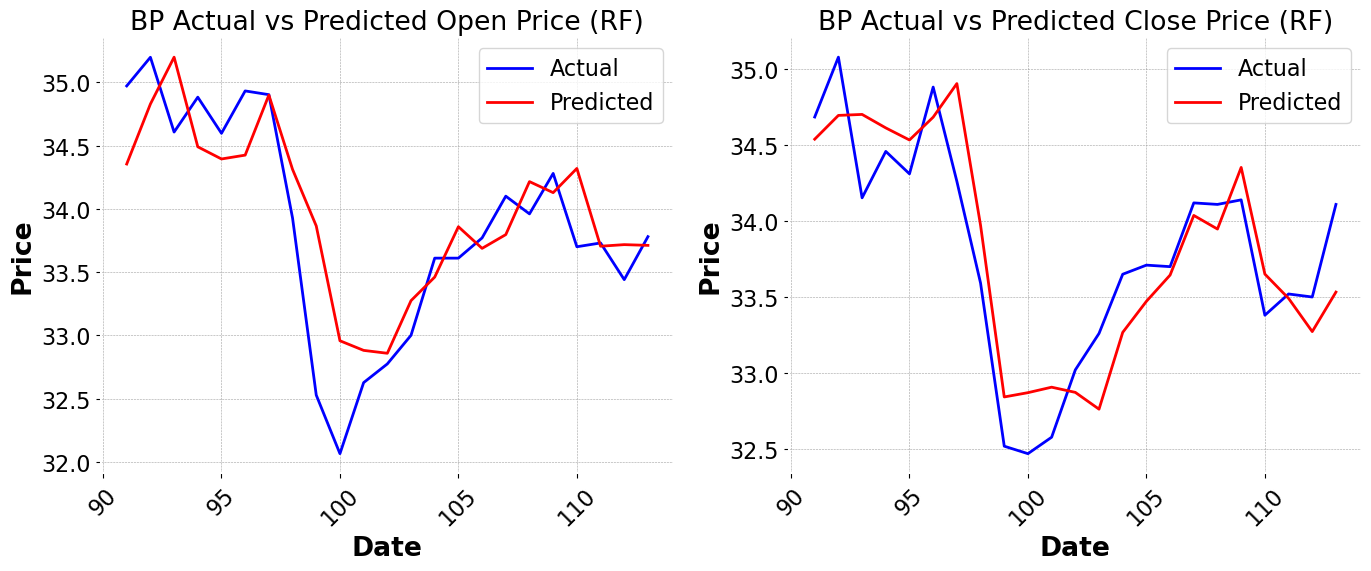

In [37]:
def plot_actual_vs_predicted(y_test, y_pred, ax, title):
    """
    Plot actual vs predicted prices.
    
    Parameters:
        y_test (pd.Series): True target values.
        y_pred (np.array): Predicted values.
        ax (matplotlib.axes.Axes): Axes object to plot on.
        title (str): Title of the plot.
    """
    ax.plot(y_test.index, y_test, label='Actual', color='blue')
    ax.plot(y_test.index, y_pred, label='Predicted', color='red')
    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.legend()
    ax.tick_params(axis='x', rotation=45)

# Plotting the results for Shell data
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for idx, result in enumerate(shell_rf_results):
    y_test, y_pred, target_col = result
    plot_actual_vs_predicted(y_test, y_pred, axes[idx], f'Shell Actual vs Predicted {target_col} Price (RF)')

plt.tight_layout()
plt.show()

# Plotting the results for BP data
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for idx, result in enumerate(bp_rf_results):
    y_test, y_pred, target_col = result
    plot_actual_vs_predicted(y_test, y_pred, axes[idx], f'BP Actual vs Predicted {target_col} Price (RF)')

plt.tight_layout()
plt.show()


### Learning Curves for Linear Regression and Random Forest Models

In [38]:
def plot_learning_curve(estimator, X, y, ax, title, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    """
    Plot learning curve for a given model.
    
    Parameters:
        estimator (object): The model to train.
        X (pd.DataFrame): Features DataFrame.
        y (pd.Series): Target Series.
        ax (matplotlib.axes.Axes): Axes object to plot on.
        title (str): Title of the plot.
        ylim (tuple): Limits for the y-axis.
        cv (int): Number of cross-validation folds.
        n_jobs (int): Number of jobs to run in parallel.
        train_sizes (np.array): Array of training set sizes to use.
    """
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_mean_squared_error')
    
    train_scores_mean = -np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    sns.set_style("whitegrid")
    sns.despine()
    
    ax.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    ax.legend(loc="best")
    ax.set_title(title)

    # Display MSE values on the plot
    ax.text(0.05, 0.95, f"Training MSE: {train_scores_mean[-1]:.4f}\nValidation MSE: {test_scores_mean[-1]:.4f}",
            transform=ax.transAxes, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))


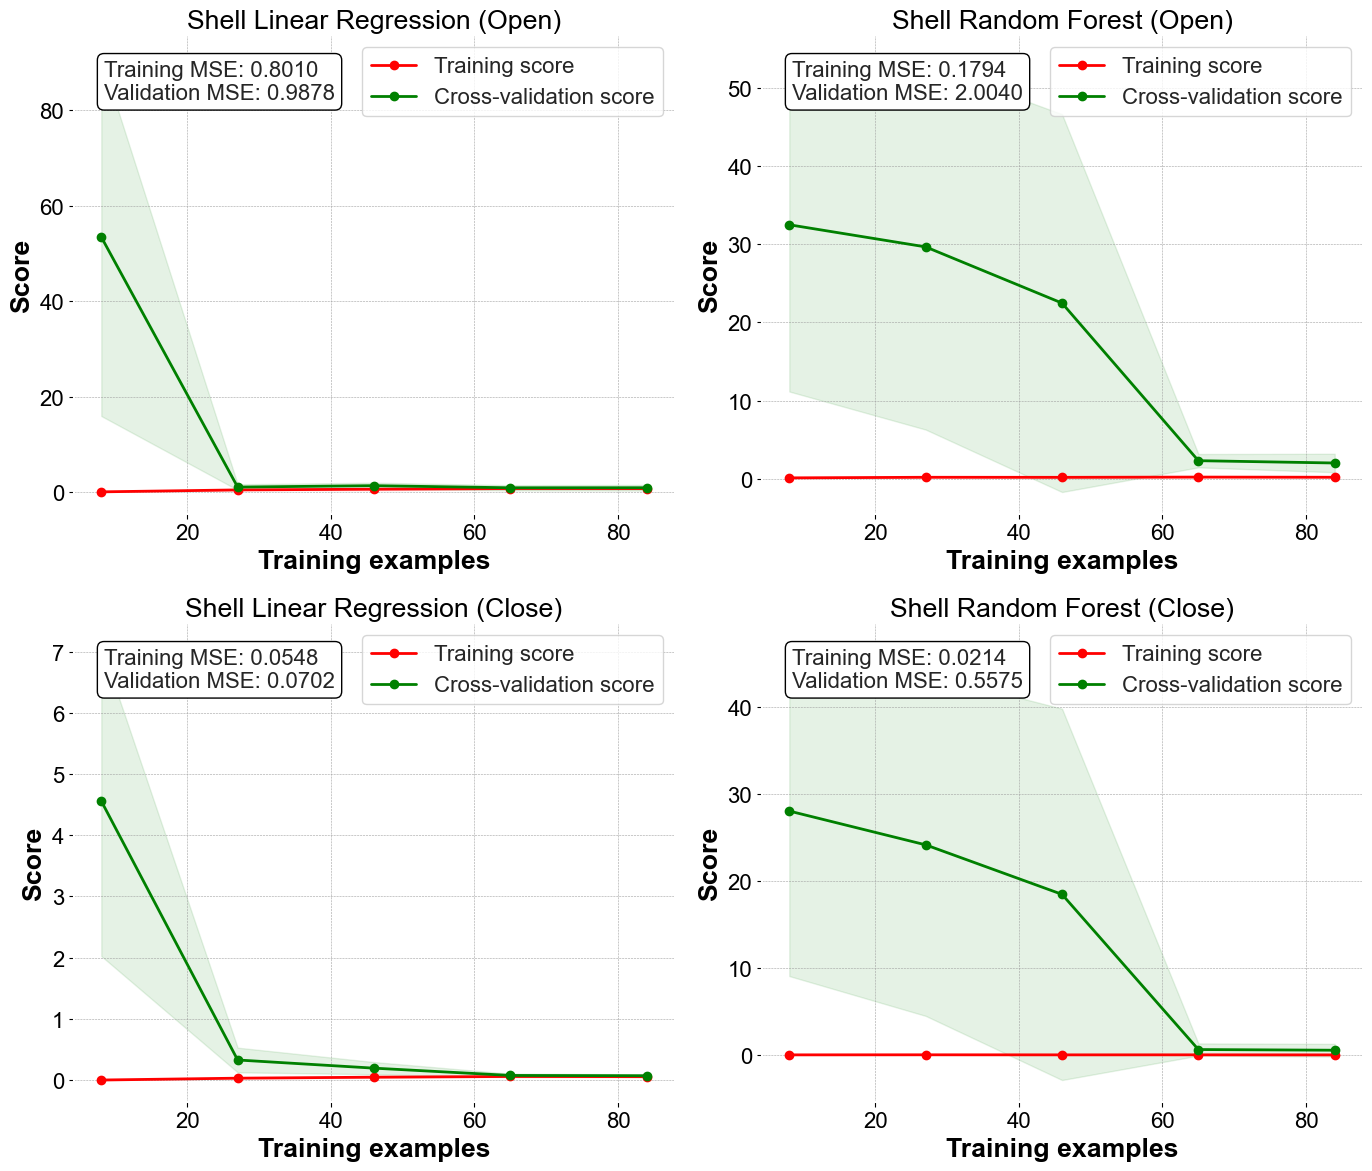

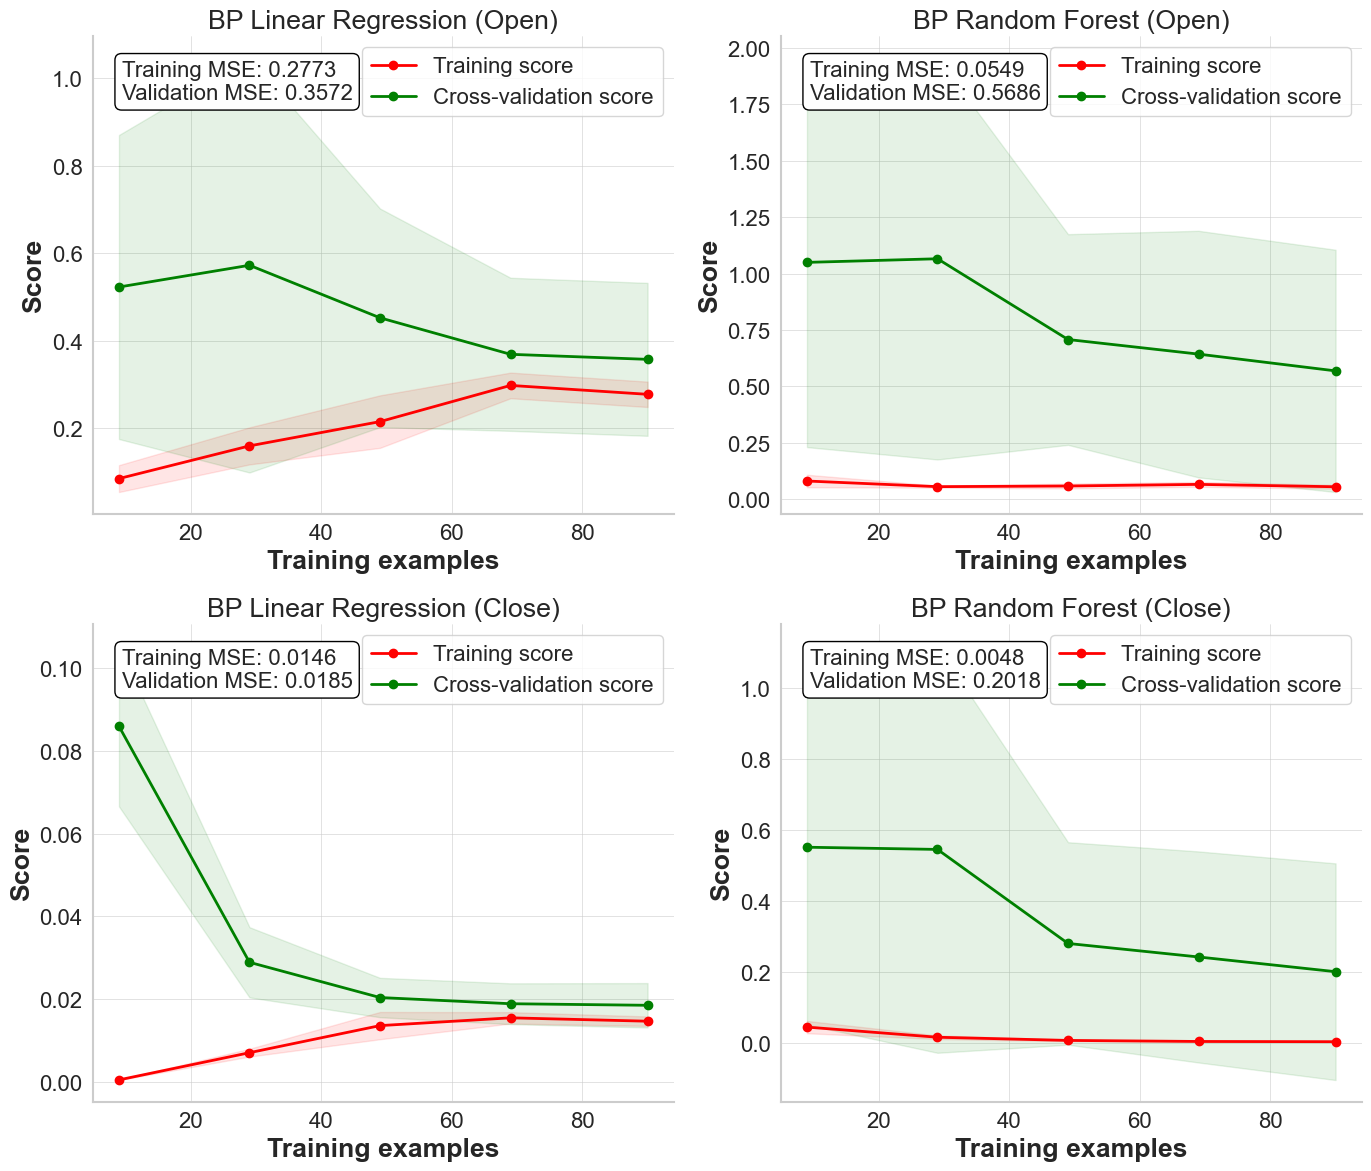

In [39]:
# Define the models
lr = LinearRegression()
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Define the feature and target columns for both models
feature_cols_open = ['prev_avg_title_sentiment', 'prev_avg_description_sentiment', 'prev_avg_content_sentiment', 'prev_Close', 'prev_Open']
feature_cols_close = ['prev_avg_title_sentiment', 'prev_avg_description_sentiment', 'prev_avg_content_sentiment', 'Open', 'High', 'Low', 'prev_Close']

# Plot learning curves for Shell data
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

X_shell_open = shell_combined_df[feature_cols_open]
y_shell_open = shell_combined_df['Open']

X_shell_close = shell_combined_df[feature_cols_close]
y_shell_close = shell_combined_df['Close']

plot_learning_curve(lr, X_shell_open, y_shell_open, axes[0, 0], "Shell Linear Regression (Open)", cv=5, n_jobs=-1)
plot_learning_curve(rf, X_shell_open, y_shell_open, axes[0, 1], "Shell Random Forest (Open)", cv=5, n_jobs=-1)

plot_learning_curve(lr, X_shell_close, y_shell_close, axes[1, 0], "Shell Linear Regression (Close)", cv=5, n_jobs=-1)
plot_learning_curve(rf, X_shell_close, y_shell_close, axes[1, 1], "Shell Random Forest (Close)", cv=5, n_jobs=-1)

plt.tight_layout()
plt.show()

# Plot learning curves for BP data
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

X_bp_open = bp_combined_df[feature_cols_open]
y_bp_open = bp_combined_df['Open']

X_bp_close = bp_combined_df[feature_cols_close]
y_bp_close = bp_combined_df['Close']

plot_learning_curve(lr, X_bp_open, y_bp_open, axes[0, 0], "BP Linear Regression (Open)", cv=5, n_jobs=-1)
plot_learning_curve(rf, X_bp_open, y_bp_open, axes[0, 1], "BP Random Forest (Open)", cv=5, n_jobs=-1)

plot_learning_curve(lr, X_bp_close, y_bp_close, axes[1, 0], "BP Linear Regression (Close)", cv=5, n_jobs=-1)
plot_learning_curve(rf, X_bp_close, y_bp_close, axes[1, 1], "BP Random Forest (Close)", cv=5, n_jobs=-1)

plt.tight_layout()
plt.show()